# Compare test and train.

This notebook is used after the training procedure and evaluation to compare the behaviour of the models on the test and train scenarios.

In [1]:
cd("..")

using Pkg
Pkg.activate(".")

  Activating project at `/mnt/NGI_disks/ebr/P/2022/01/20220127/Calculations/AP3/models/tsunami-inundation-emulator`


In [2]:
using NCDatasets, Flux, CUDA, Plots, DelimitedFiles, Distributed, DataFrames, CSV, Serialization, JSON
using Dates: format, now
using Statistics, Random, StatsPlots, StatsBase, Measures
import YAML
using BSON: @save, @load

gr()
theme(:ggplot2)

In [3]:
# Create readers for data loading.
include("scripts/datareader.jl")

rundir = "/home/ebr/projects/tsunami-inundation-emulator/article_runs/t591/mc8_l8_rel/"  
eval_train_dir = joinpath(rundir, "evaluation", "train")
eval_test_dir = joinpath(rundir, "evaluation", "BS_events")
eval_out_dir = joinpath(rundir, "evaluation", "train-BS_events")
config = DataReader.parse_config(joinpath(rundir, "config.yml"))
reader = DataReader.Reader(config)

Main.DataReader.Reader("/data_large/stg/UMA_download/", "/data_large/grids/Catania/C_CT.grd", 10, (1:912, 1:2224), (30:45, 1:480), (1, 1), (912, 2224), Float32[15.0376 14.4699 … 155.852 155.748; 14.2821 14.2657 … 155.779 155.678; … ; -2.79932 -3.02242 … -66.2616 -66.3188; -2.82395 -3.04324 … -66.4558 -66.5128], true)

In [4]:
# Create evaluation directory
if !isdir(eval_out_dir)
    mkpath(eval_out_dir)
end

# Summary statistics

In [5]:
# Load output as dataframe.
eval_test_df = CSV.File(joinpath(eval_test_dir, "summary_results.txt"); delim='\t') |> DataFrame;
eval_train_df = CSV.File(joinpath(eval_train_dir, "summary_results.txt"); delim='\t') |> DataFrame;
unique!(eval_test_df, :scenario)
unique!(eval_train_df, :scenario)
# sort!(test_df, [:error]);

In [6]:
names(eval_test_df)

5-element Vector{String}:
 "scenario"
 "l2_err"
 "l1_err"
 "l2_norm"
 "l1_norm"

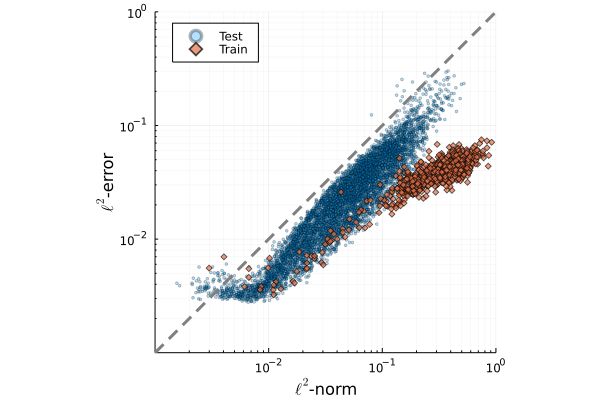

In [7]:
#theme(:ggplot2)
#theme(:wong)
theme(:default)
p = scatter(
    eval_test_df.l2_norm, 
    eval_test_df.l2_err, 
    scale = :log10, 
    xlabel="\$\\ell^2\$-norm", 
    ylabel="\$\\ell^2\$-error", 
    label = "Test", 
    markershape=:circle,
    markersize = 1.5,
    minorgrid = true,
    alpha=0.3,
    legend=:topleft,
    ylims=(1e-3,0),
    xlims=(1e-3,0),
    ticks=[1e-2,1e-1,1],
    dpi=300,
    aspect_ratio = 1.
)
p = scatter!(
    p,
    eval_train_df.l2_norm, 
    eval_train_df.l2_err,
    label = "Train",
    alpha=0.7,
    markershape=:diamond,
    markersize = 3,
)
plot!(p, [1e-3,1],[1e-3,1], linestyle=:dash, linewidth=3, linecolor=:grey, label="")

savefig(p, joinpath(eval_out_dir, "norm_error.png"))
display(p)

In [8]:
eval_test_df[!, "rel_error"] = eval_test_df.l2_err./eval_test_df.l2_norm;
eval_train_df[!, "rel_error"] = eval_train_df.l2_err./eval_train_df.l2_norm;

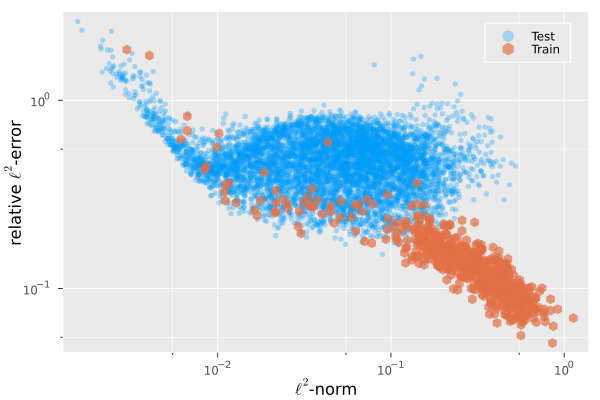

In [9]:
theme(:ggplot2)
p = scatter(
    eval_test_df.l2_norm, 
    eval_test_df.rel_error, 
    scale = :log10, 
    xlabel="\$\\ell^2\$-norm", 
    ylabel="relative \$\\ell^2\$-error", 
    label = "Test",
    markershape=:circle,
    markersize = 3,
    alpha=0.3,
    legend=:topright
)

p = scatter!(
    p,
    eval_train_df.l2_norm, 
    eval_train_df.rel_error, 
    scale = :log10, 
    label = "Train",
    alpha=0.7,
    markershape=:hexagon,
    markersize = 5,
)


savefig(p, joinpath(eval_test_dir, "rel_error_norm.svg"))
display(p)

# Pointwise predictions.

In [10]:
poi_preds_test_df = CSV.File(joinpath(eval_test_dir, "point_predictions.txt"); delim='\t') |> DataFrame;
poi_preds_train_df = CSV.File(joinpath(eval_train_dir, "point_predictions.txt"); delim='\t') |> DataFrame;

In [11]:
# Create mask for test points from file test_points.txt
ct_mask = BitArray(readdlm(joinpath(rundir, "ct_mask.txt"), '\t',Bool, '\n'));
aspect_ratio = config["scale"][1]/config["scale"][2] # Pixel shape.
selected_mask = falses(size(ct_mask))

poi_df = CSV.File(joinpath(rundir, "test_points.txt"); delim='\t') |> DataFrame;
for df_row in eachrow(poi_df)
    #println("point_nr: $(df_row.point_nr), row: $(df_row.row), col: $(df_row.col)")
    selected_mask[df_row.row, df_row.col] = true
end

In [12]:
# subset of points.
target_front_cols = [Symbol("t$i") for i in poi_df[poi_df[!, "shore-front"] .== true, :point_nr]];
pred_front_cols = [Symbol("p$i") for i in poi_df[poi_df[!, "shore-front"] .== true, :point_nr]];
target_back_cols = [Symbol("t$i") for i in poi_df[poi_df[!, "shore-back"] .== true, :point_nr]];
pred_back_cols = [Symbol("p$i") for i in poi_df[poi_df[!, "shore-back"] .== true, :point_nr]];

### Comparisson of covariance structure.

Below are som plots of the estimated covariance of the inundation height at the specific points.

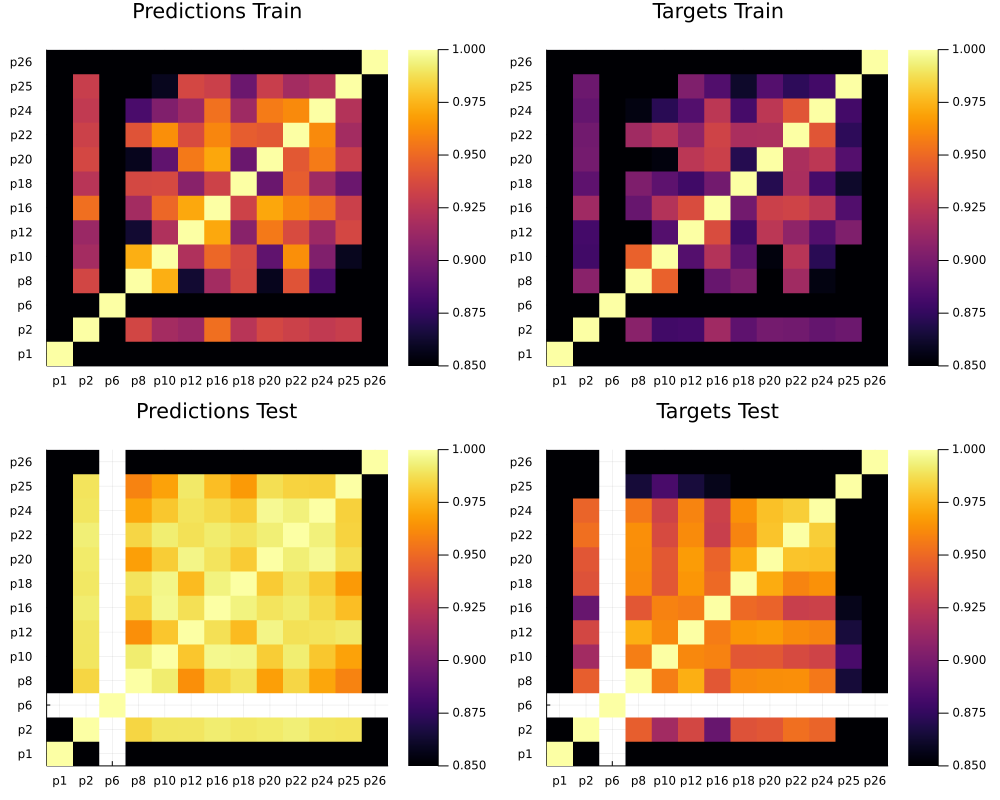

In [13]:
# Along the shoreline front
theme(:default)
clim = (0.85, 1)
p1 = heatmap(
    cor(Matrix(poi_preds_train_df[!, pred_front_cols]));
    xticks=(1:length(pred_front_cols), pred_front_cols),
    yticks=(1:length(pred_front_cols), pred_front_cols),
    clim = clim,
    top_margin=5mm
)
# Unnormalized covariance matrix
p2 = heatmap(
    cor(Matrix(poi_preds_train_df[!, target_front_cols]));
    xticks=(1:length(pred_front_cols), pred_front_cols),
    yticks=(1:length(pred_front_cols), pred_front_cols),
    clim = clim,
    top_margin = 5mm
)

# Unnormalized covariance matrix
p3 = heatmap(
    cor(Matrix(poi_preds_test_df[!, pred_front_cols]));
    xticks=(1:length(pred_front_cols), pred_front_cols),
    yticks=(1:length(pred_front_cols), pred_front_cols),
    clim = clim,
    top_margin = 5mm
)

# Unnormalized covariance matrix
p4 = heatmap(
    cor(Matrix(poi_preds_test_df[!, target_front_cols]));
    xticks=(1:length(pred_front_cols), pred_front_cols),
    yticks=(1:length(pred_front_cols), pred_front_cols),
    clim = clim,
    top_margin = 5mm
)


p = plot(p1, p2, p3, p4, layout = (2,2), size=(1000,800), title=["Predictions Train" "Targets Train" "Predictions Test" "Targets Test"])
savefig(p, joinpath(eval_out_dir, "corelations_front.svg"))
display(p)

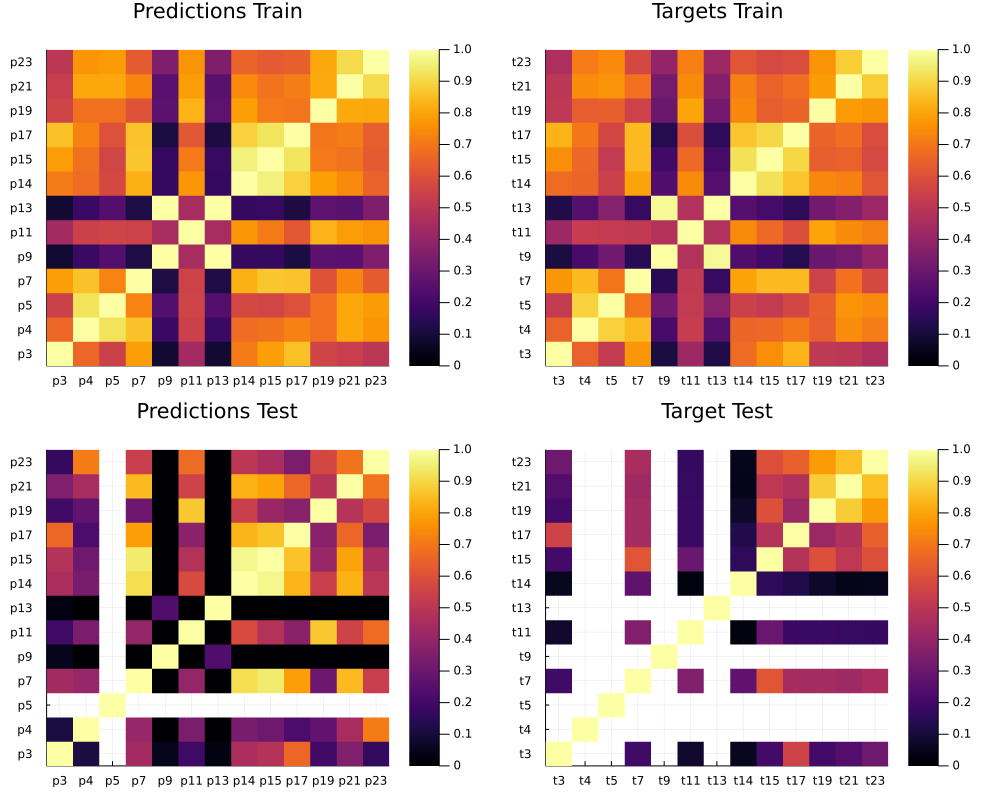

In [14]:
# Along the shoreline back
clim = (0.,1.)

p1 = heatmap(
    cor(Matrix(poi_preds_train_df[!, pred_back_cols]));
    xticks=(1:length(pred_back_cols), pred_back_cols),
    yticks=(1:length(pred_back_cols), pred_back_cols),
    clim = clim,
    top_margin=5mm
)

# Unnormalized covariance matrix
p2 = heatmap(
    cor(Matrix(poi_preds_train_df[!, target_back_cols]));
    xticks=(1:length(pred_back_cols), target_back_cols),
    yticks=(1:length(pred_back_cols), target_back_cols),
    clim = clim,
    top_margin=5mm
)
p3 = heatmap(
    cor(Matrix(poi_preds_test_df[!, pred_back_cols]));
    xticks=(1:length(pred_back_cols), pred_back_cols),
    yticks=(1:length(pred_back_cols), pred_back_cols),
    clim = clim,
    top_margin=5mm
)

# Unnormalized covariance matrix
p4 = heatmap(
    cor(Matrix(poi_preds_test_df[!, target_back_cols]));
    xticks=(1:length(pred_back_cols), target_back_cols),
    yticks=(1:length(pred_back_cols), target_back_cols),
    clim = clim,
    top_margin=5mm
)


p = plot(p1, p2, p3, p4, layout = (2,2), size=(1000,800), title=["Predictions Train" "Targets Train" "Predictions Test" "Target Test"])
savefig(p, joinpath(eval_out_dir, "corelations_back.svg"))
display(p)

Note the huge difference in correlation structure! Note also that the predictions are in general more correlated than the targets, except for certain extreme points.

### Quality of pointwise predictions.

In [15]:
function r2(predictions, targets)
    residual_sum_of_squares = sum((targets .- predictions).^2)
    total_sum_of_squares = sum((targets .- mean(targets)).^2)
    1 - residual_sum_of_squares/total_sum_of_squares
end

r2 (generic function with 1 method)

In [16]:
poi_preds_train_df

600×52 DataFrame
 Row │ p1         p2        p3        p4         p5         p6         p7      ⋯
     │ Float64    Float64   Float64   Float64    Float64    Float64    Float64 ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 0.0        0.152114  0.356729  0.0        0.0        0.0        0.0     ⋯
   2 │ 0.0        2.41406   2.95479   0.0        0.0        0.0        0.0
   3 │ 0.0        3.3848    3.83404   0.0        0.0        0.0        0.0
   4 │ 0.0        1.99688   2.98709   0.0        0.0        0.0        0.0
   5 │ 1.05198    5.16004   5.78128   0.572503   0.0208857  0.0        1.26935 ⋯
   6 │ 0.0        1.7057    2.25214   0.0        0.0        0.0        0.0
   7 │ 1.57361    5.37948   6.11006   0.879117   0.256681   0.0559006  1.62318
   8 │ 0.0        1.68845   2.23219   0.0        0.0        0.0        0.0
   9 │ 0.894807   4.92847   6.06142   0.569428   0.0546864  0.0        1.30581 ⋯
  10 │ 0.588701   4.46092   4.96691   0.0        0.0        0.0        0.58369
  11 │ 1.65452    5.43554   5.30336   0.147929   0.0212276  0.0        0.40440
  ⋮  │     ⋮         ⋮         ⋮          ⋮          ⋮          ⋮         ⋮    ⋱
 591 │ 0.0285816  3.84406   4.14332   0.0        0.0        0.0        0.0
 592 │ 0.263742   4.24134   4.52418   0.0        0.0        0.0        0.70763 ⋯
 593 │ 0.0        0.336082  0.589115  0.0        0.0        0.0        0.0
 594 │ 0.0        0.812449  1.23295   0.0        0.0        0.0        0.0
 595 │ 0.835387   4.85748   5.37859   0.371527   0.0        0.0        1.25817
 596 │ 0.0        2.81763   2.91792   0.0        0.0        0.0        0.0     ⋯
 597 │ 1.65452    5.43554   5.30336   0.147929   0.0212276  0.0        0.40440
 598 │ 1.99088    5.7539    5.79805   0.916501   0.266132   0.0        0.87020
 599 │ 0.0        3.2511    3.70065   0.0        0.0        0.0        0.0
 600 │ 1.67353    5.9081    6.5264    1.66304    0.832674   0.488666   2.04412 ⋯
                                                 46 columns and 579 rows omitted

In [17]:
poi_df

26×5 DataFrame
 Row │ point_nr  row    col    shore-front  shore-back 
     │ Int64     Int64  Int64  Int64        Int64      
─────┼─────────────────────────────────────────────────
   1 │        1    840      1            1           0
   2 │        2    880      1            1           0
   3 │        3    496    208            0           1
   4 │        4    556    208            0           1
   5 │        5    616    208            0           1
   6 │        6    652    207            1           0
   7 │        7    588    408            0           1
   8 │        8    625    408            1           0
   9 │        9    572    608            0           1
  10 │       10    612    608            1           0
  11 │       11    568    808            0           1
  ⋮  │    ⋮        ⋮      ⋮         ⋮           ⋮
  17 │       17    568   1208            0           1
  18 │       18    605   1208            1           0
  19 │       19    548   1408            0           1
  20 │       20    588   1408            1           0
  21 │       21    532   1608            0           1
  22 │       22    570   1608            1           0
  23 │       23    524   1808            0           1
  24 │       24    562   1808            1           0
  25 │       25    646   2008            1           0
  26 │       26    691   2008            1           0
                                         5 rows omitted

In [18]:
stats_df = DataFrame()

function class(row)
    if row."shore-front" == 1
        return "Front"
    elseif row."shore-back" == 1
        return "Back"
    else
        return "None"
    end
end

for row in eachrow(poi_df)
    pred, target = Symbol("p$(row.point_nr)"), Symbol("t$(row.point_nr)")
    push!(stats_df,
        (point = pred,
        r2_test = r2(poi_preds_test_df[!, pred], poi_preds_test_df[!, target]),
        r2_train = r2(poi_preds_train_df[!, pred], poi_preds_train_df[!, target]),
        shore_front = row."shore-front",
        shore_back = row."shore-back",
        class = class(row))
    )
end 

In [19]:
stats_df

26×6 DataFrame
 Row │ point   r2_test         r2_train  shore_front  shore_back  class  
     │ Symbol  Float64         Float64   Int64        Int64       String 
─────┼───────────────────────────────────────────────────────────────────
   1 │ p1           0.288437   0.901279            1           0  Front
   2 │ p2           0.664509   0.969742            1           0  Front
   3 │ p3           0.754694   0.975635            0           1  Back
   4 │ p4        -Inf          0.97517             0           1  Back
   5 │ p5         NaN          0.968554            0           1  Back
   6 │ p6         NaN          0.917731            1           0  Front
   7 │ p7         -19.9872     0.983583            0           1  Back
   8 │ p8           0.68343    0.976216            1           0  Front
   9 │ p9        -Inf          0.892417            0           1  Back
  10 │ p10          0.734973   0.964288            1           0  Front
  11 │ p11         -9.98479    0.964749            0           1  Back
  ⋮  │   ⋮           ⋮            ⋮           ⋮           ⋮         ⋮
  17 │ p17          0.217083   0.976601            0           1  Back
  18 │ p18          0.612635   0.967117            1           0  Front
  19 │ p19         -0.155364   0.93735             0           1  Back
  20 │ p20          0.624318   0.957165            1           0  Front
  21 │ p21         -0.057219   0.949224            0           1  Back
  22 │ p22          0.687978   0.968539            1           0  Front
  23 │ p23          0.129476   0.951719            0           1  Back
  24 │ p24          0.534166   0.967293            1           0  Front
  25 │ p25          0.687735   0.962042            1           0  Front
  26 │ p26          0.0614573  0.925094            1           0  Front
                                                           5 rows omitted

In [20]:
theme(:default)

p = @df stats_df[stats_df.shore_front .== 1,:] scatter(
    :r2_train, 
    :r2_test,  
    xlabel="\$r^2\$ on training set.", 
    ylabel="\$r^2\$ on test set.", 
    label = "Shore front",
    marker = (15, 0.3, :blue),
    legend=:bottomright,
    ylims=(0.7,1.),
    xlims=(0.88,1),
    dpi=300
)

@df stats_df[stats_df.shore_back .== 1,:] scatter!(p,
    :r2_train, 
    :r2_test,  
    label = "Shore back",
    marker = (15, 0.3, :orange)
)

annotate_points = [Symbol("p$i") for i in [6,21,23,19,26,1,5,4,14,17,11,15,7,3]]
filter(:point => s -> s in annotate_points, stats_df)

@df filter(:point => s -> s in annotate_points, stats_df) annotate!(p, 
    :r2_train, 
    :r2_test,
    [text("$i"[2:end], 8, :center) for i in :point]
)
plot!(p, [0,1],[0,1], linestyle=:dash, linewidth=3, linecolor=:grey, label="\$r^2_{test} = r^2_{train}\$")

savefig(p, joinpath(eval_out_dir, "r2r2.png"))
display(p)

GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


In [21]:
function make_scatter_plot(point, lim, show=true)
    point = string(point)
    p = scatter(
        poi_preds_test_df[!,"p"*point],
        poi_preds_test_df[!,"t"*point], 
        #xlabel="prediction", 
        #ylabel="target", 
        label="Test",
        margins=2mm,
        markershape=:circle,
        markersize = 3,
        alpha=0.1,
        #legend=:topleft,
        legend=false,
        xlims=(0,lim),
        ylims=(0,lim),
        dpi=300,
        aspect_ratio = 1.,
        tickfontsize = 12
    )

    p = @df poi_preds_train_df scatter!(p,
        poi_preds_train_df[!,"p"*point],
        poi_preds_train_df[!,"t"*point],
        alpha=0.6, 
        label="Train",
        markershape=:diamond,
        markersize = 3
    )
    plot!(p, [0,lim],[0,lim], linestyle=:dash, linewidth=3, linecolor=:grey, label="")
    hspan!(p,[0,lim], color = :gray, alpha = 0.1, labels = "")
    savefig(p, joinpath(eval_out_dir, "scatter_p"*point*".png"))
    if show
        display(p)
    end
end

make_scatter_plot (generic function with 2 methods)

In [22]:
# make all scatterplots.
for row in eachrow(stats_df)
    make_scatter_plot(string(row.point)[2:end], 8, false)
end

In [23]:
make_scatter_plot(26, 8)

In [24]:
make_scatter_plot(1, 8)

In [25]:
make_scatter_plot(20, 3)

In [26]:
make_scatter_plot(19, 2)

In [27]:
#avefig(scatter_front_plots[20], joinpath(eval_out_dir, "scatter_p18.svg"))

In [28]:
stats_df[stats_df.shore_back .== 1,:]

13×6 DataFrame
 Row │ point   r2_test        r2_train  shore_front  shore_back  class  
     │ Symbol  Float64        Float64   Int64        Int64       String 
─────┼──────────────────────────────────────────────────────────────────
   1 │ p3           0.754694  0.975635            0           1  Back
   2 │ p4        -Inf         0.97517             0           1  Back
   3 │ p5         NaN         0.968554            0           1  Back
   4 │ p7         -19.9872    0.983583            0           1  Back
   5 │ p9        -Inf         0.892417            0           1  Back
   6 │ p11         -9.98479   0.964749            0           1  Back
   7 │ p13       -Inf         0.904773            0           1  Back
   8 │ p14     -10082.7       0.960655            0           1  Back
   9 │ p15         -3.53999   0.956248            0           1  Back
  10 │ p17          0.217083  0.976601            0           1  Back
  11 │ p19         -0.155364  0.93735             0           1  Back
  12 │ p21         -0.057219  0.949224            0           1  Back
  13 │ p23          0.129476  0.951719            0           1  Back

In [29]:
#savefig(scatter_back_plots[26], joinpath(eval_out_dir, "scatter_p17.svg"))

In [30]:
#scatter_front_plots = make_scatter_plots(stats_df[stats_df.shore_front .== 1,:], 0:1:10, 10);
#scatter_back_plots = make_scatter_plots(stats_df[stats_df.shore_back .== 1,:], 0:0.5:4, 4, 45);

In [31]:
theme(:ggplot2)
layout = (ceil(Int16, length(scatter_front_plots)/3),3)
p = plot(scatter_front_plots..., layout=layout, legend=false, size=(3000, 6000))
savefig(p, joinpath(eval_out_dir, "scatter_front.svg"))
#display(p)

LoadError: UndefVarError: scatter_front_plots not defined

In [32]:
layout = (ceil(Int16, length(scatter_back_plots)/3),3)
p = plot(scatter_back_plots..., layout=layout, legend=false, size=(3000,6000))
savefig(p, joinpath(eval_out_dir, "scatter_back.svg"))
#display(p)

LoadError: UndefVarError: scatter_back_plots not defined

In [33]:
preds_df = poi_preds_df[:, pred_front_cols];
targets_df = poi_preds_df[:, target_front_cols];

rename!(preds_df, pred_front_cols);
rename!(targets_df, pred_front_cols);

preds_df_stacked = stack(preds_df)
targets_df_stacked = stack(targets_df)

@df preds_df_stacked[preds_df_stacked.value .> 1.,:] violin(:variable, :value, label="Predictions", side=:left, xrotation=45, ylabel="Depth")
@df targets_df_stacked[targets_df_stacked.value .> 1.,:] violin!(:variable, :value, label="Targets", side=:right)

LoadError: UndefVarError: poi_preds_df not defined

In [34]:
preds_df = poi_preds_df[:, pred_back_cols];
target_df = poi_preds_df[:, target_back_cols];

rename!(preds_df, pred_back_cols);
rename!(target_df, pred_back_cols);

preds_df_stacked = stack(preds_df)
target_df_stacked = stack(target_df)

@df preds_df_stacked[preds_df_stacked.value .> 1.,:] dotplot(:variable, :value, label="Predictions", alpha=0.5, side=:left, xrotation=45)
@df target_df_stacked[target_df_stacked.value .> 1.,:] dotplot!(:variable, :value, label="Targets", alpha=0.5, side=:right)

LoadError: UndefVarError: poi_preds_df not defined

# Accuracy metrics

Let $P_i, S_i$ be the predicted and the simulated flow-depth at locations $1 \leq i \leq N$. Let $K_i = S_i/P_i$. Aida measured the accuracy in terms of a geometric mean ratio $K$ given by

$$
    \log(K) = \frac{1}{N} \sum_{i=1}^N \log\left(K_i\right).
$$

Note that $K$ may be considered as a kind of correction factor. 
Its standard deviation 

$$
    \log(\kappa) = \left(\frac{1}{N}\sum_{i=1}^N\left[\left(\log(S_i/P_i)\right)^2 - \left(\log(K)\right)^2\right]\right)^{1/2}
$$

is a measure of the fluctuation of this correction factor.
Note that it is only defined for positive numbers, and so it is not suitable at the boundary of the inundation area, when measuring flow-depth.

Another measure applied in \cite{muliaMachineLearningbasedTsunami2022} is the goodness-of-fit $G$ defined by  

\begin{equation}
    \sum_{i=1}^N w_i^2S_iP_i = \frac{1-G}{2}\left(\sum_{i=1}^N w_i^2O_i^2 + \sum_{i=1}^N w_i^2P_i^2\right).
\end{equation}

where $w_i$ are some nonnegative weights. It follows from H\"older's and Young's inequality that $0 \leq G \leq 1$ where $G = 0$ only if predictions and simulations are equal. 

In [35]:
aida_df = CSV.File(joinpath(eval_out_dir, "summary_by_class.txt"); delim='\t', missingstring="missing") |> DataFrame;

LoadError: ArgumentError: "/home/ebr/projects/tsunami-inundation-emulator/article_runs/t591/mc8_l8_rel/evaluation/train-BS_events/summary_by_class.txt" is not a valid file or doesn't exist

In [36]:
names(aida_df)

LoadError: UndefVarError: aida_df not defined

In [37]:
p = @df aida_df[aida_df.nr_of_samples_aida .> 100 .&& aida_df.class .> 1,:] boxplot(
    string.(:class), 
    :K, label="", 
    xlabel = "Depth class", 
    ylabel = "K", 
    yaxis=:identity, 
    outliers=:false
)
plot!(p, [0,3],[1,1], linestyle=:dash, linewidth=3, linecolor=:grey, label="")

savefig(p, joinpath(eval_out_dir, "aida_K_box.svg"))
display(p)
#@df aida_df[.!isnan.(aida_df.K),:] boxplot(string.(aida_class[:class]), :K, label="")

LoadError: UndefVarError: aida_df not defined

In [38]:
p = @df aida_df[aida_df.nr_of_samples_aida .> 100 .&& aida_df.class .> 1,:] boxplot(
    string.(:class), 
    :kappa, label="", 
    xlabel="Depth class", 
    ylabel="\$\\kappa\$", 
    outliers=:false
)
savefig(p, joinpath(eval_out_dir, "aida_kappa_box.svg"))
display(p)

LoadError: UndefVarError: aida_df not defined

In [39]:
p = @df aida_df[aida_df.nr_of_samples_res .> 100,:] boxplot(
    string.(:class), 
    :mean_res, 
    label="", 
    xlabel = "Depth class", 
    ylabel = "mean residual", 
    yaxis=:identity, 
    outliers=:false
)
plot!(p, [0,4],[0,0], linestyle=:dash, linewidth=3, linecolor=:grey, label="")

savefig(p, joinpath(eval_out_dir, "mean_residuals.svg"))
display(p)

LoadError: UndefVarError: aida_df not defined

In [40]:
p = @df aida_df[aida_df.nr_of_samples_res .> 100,:] boxplot(
    string.(:class), 
    :q_res, 
    label="", 
    xlabel = "Depth class", 
    ylabel = "\$Q_{|r|}(0.95)\$", 
    yaxis=:identity,
    outliers=:false
)

savefig(p, joinpath(eval_out_dir, "q_residuals.svg"))
display(p)

LoadError: UndefVarError: aida_df not defined

In [41]:
p = @df aida_df[aida_df.nr_of_samples_res .> 100,:] boxplot(
    string.(:class), 
    :std_res, 
    label="", 
    xlabel = "Depth class", 
    ylabel = "\$\\sigma_r\$", 
    yaxis=:identity,
    outliers=:false
)

savefig(p, joinpath(eval_out_dir, "std_residuals.svg"))
display(p)

LoadError: UndefVarError: aida_df not defined

To save the notebook for later use:
```terminal
jupyter nbconvert --to html evaluate-model.ipynb --output-dir [Folder] --out [filename without extension]
```